### 前置作業

#### 載入模組

In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### 準備資料集

In [2]:
def generate_sin_dataset(n_samples, n_points, noise_std):
    x = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    phi = np.random.uniform(0, 2*np.pi, size=n_samples)

    signals = np.sin(x[None, :] + phi[:, None])

    if noise_std > 0:
        noise = np.random.normal(0, noise_std, size=signals.shape)
        signals = signals + noise

    max_idx = np.argmax(signals, axis=1)
    x_max = x[max_idx]

    labels = ((0 < x_max) & (x_max < np.pi)).astype(int)

    return signals, labels


#### 切分資料

In [3]:
def split_dataset(signals, labels, train_ratio=0.8, val_ratio=0.1):
    N = len(signals)
    indices = np.random.permutation(N)

    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    data = {
        "train": (signals[train_idx], labels[train_idx]),
        "val":   (signals[val_idx],   labels[val_idx]),
        "test":  (signals[test_idx],  labels[test_idx])
    }
    return data

In [4]:
signals, labels = generate_sin_dataset(
    n_samples=5000,
    n_points=1000,
    noise_std=0.6
)

data = split_dataset(signals, labels)

#### 展示測試數據

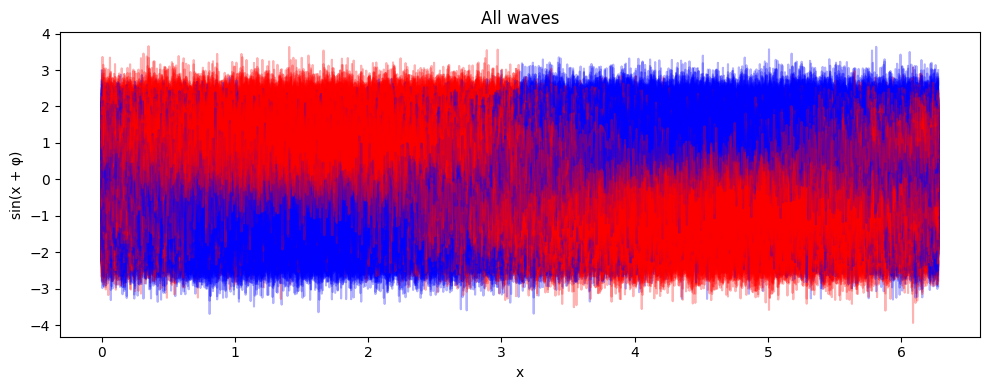

In [5]:
x = np.linspace(0, 2*np.pi, 1000, endpoint=False)

plt.figure(figsize=(10, 4))
for sig, lab in zip(signals, labels):
    color = 'red' if lab == 1 else 'blue'
    plt.plot(x, sig, color=color, alpha=0.3)
plt.title("All waves")
plt.xlabel("x")
plt.ylabel("sin(x + φ)")
plt.tight_layout()
plt.show()


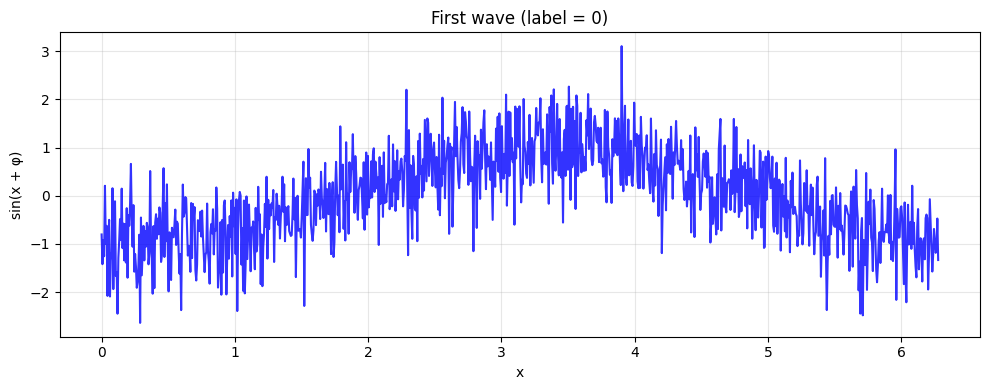

In [6]:
sig = signals[0]
lab = labels[0]

plt.figure(figsize=(10, 4))
color = 'red' if lab == 1 else 'blue'
plt.plot(x, sig, color=color, alpha=0.8)
plt.title(f"First wave (label = {lab})")
plt.xlabel("x")
plt.ylabel("sin(x + φ)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

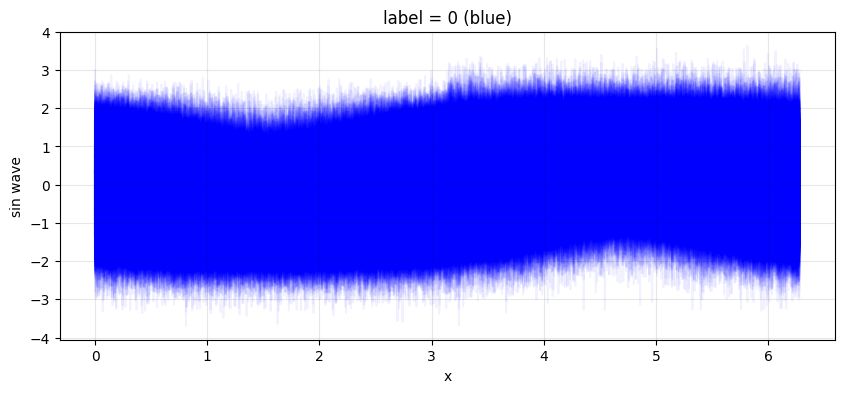

In [7]:
plt.figure(figsize=(10, 4))
for sig in signals[labels == 0]:
    plt.plot(x, sig, color="blue", alpha=0.05)
plt.title("label = 0 (blue)")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.show()

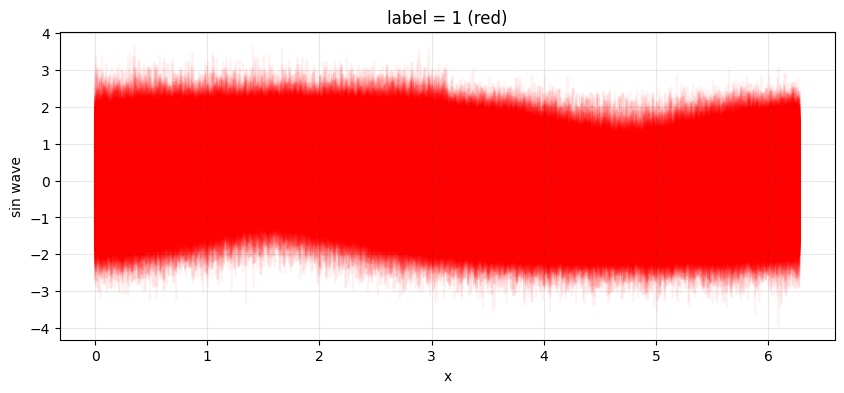

In [8]:
plt.figure(figsize=(10, 4))
for sig in signals[labels == 1]:
    plt.plot(x, sig, color="red", alpha=0.05)
plt.title("label = 1 (red)")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
print("Number of label 0 samples:", np.sum(labels == 0))
print("Number of label 1 samples:", np.sum(labels == 1))

Number of label 0 samples: 2526
Number of label 1 samples: 2474


#### 轉換資料集

In [10]:
X_train = torch.tensor(data['train'][0], dtype=torch.float32)
y_train = torch.tensor(data['train'][1], dtype=torch.float32).unsqueeze(1)

X_val = torch.tensor(data['val'][0], dtype=torch.float32)
y_val = torch.tensor(data['val'][1], dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(data['test'][0], dtype=torch.float32)
y_test = torch.tensor(data['test'][1], dtype=torch.float32).unsqueeze(1)

### 訓練模型

#### 建立神經網路

In [13]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


model = SimpleNN(input_dim=1000)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#### 進行訓練

In [14]:
num_epochs = 3000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 100/3000, Loss: 0.1990, Val Loss: 0.2874
Epoch 200/3000, Loss: 0.0719, Val Loss: 0.3669
Epoch 300/3000, Loss: 0.0205, Val Loss: 0.5074
Epoch 400/3000, Loss: 0.0088, Val Loss: 0.6102
Epoch 500/3000, Loss: 0.0048, Val Loss: 0.6842
Epoch 600/3000, Loss: 0.0031, Val Loss: 0.9067
Epoch 700/3000, Loss: 0.0021, Val Loss: 1.2839
Epoch 800/3000, Loss: 0.0016, Val Loss: 1.3182
Epoch 900/3000, Loss: 0.0012, Val Loss: 1.3469
Epoch 1000/3000, Loss: 0.0009, Val Loss: 1.5404
Epoch 1100/3000, Loss: 0.0008, Val Loss: 1.5635
Epoch 1200/3000, Loss: 0.0006, Val Loss: 1.5844
Epoch 1300/3000, Loss: 0.0005, Val Loss: 1.6038
Epoch 1400/3000, Loss: 0.0004, Val Loss: 1.6220
Epoch 1500/3000, Loss: 0.0004, Val Loss: 1.6388
Epoch 1600/3000, Loss: 0.0003, Val Loss: 1.6547
Epoch 1700/3000, Loss: 0.0003, Val Loss: 1.6696
Epoch 1800/3000, Loss: 0.0002, Val Loss: 1.6842
Epoch 1900/3000, Loss: 0.0002, Val Loss: 1.6976
Epoch 2000/3000, Loss: 0.0002, Val Loss: 1.7106
Epoch 2100/3000, Loss: 0.0002, Val Loss: 1.7235
E

#### 帶入訓練結果

In [17]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).numpy().flatten()
    y_val_pred   = model(X_val).numpy().flatten()
    y_test_pred  = model(X_test).numpy().flatten()

y_train_pred_label = (y_train_pred > 0.5).astype(int)
y_val_pred_label   = (y_val_pred > 0.5).astype(int)
y_test_pred_label  = (y_test_pred > 0.5).astype(int)

X_train_np = X_train.numpy()
X_val_np   = X_val.numpy()
X_test_np  = X_test.numpy()

y_train_np = y_train.numpy().flatten()
y_val_np   = y_val.numpy().flatten()
y_test_np  = y_test.numpy().flatten()

x = np.linspace(0, 2*np.pi, 1000, endpoint=False)

### 結果展示

#### 圖表展示

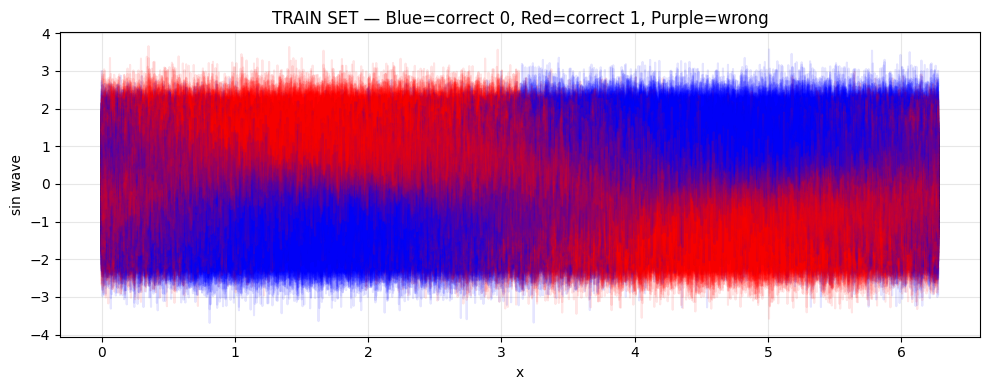

In [18]:
plt.figure(figsize=(10, 4))
for sig, t, p in zip(X_train_np, y_train_np, y_train_pred_label):
    if t == 0 and p == 0:
        plt.plot(x, sig, color="blue", alpha=0.1)
    elif t == 1 and p == 1:
        plt.plot(x, sig, color="red", alpha=0.1)
    else:
        plt.plot(x, sig, color="purple", alpha=0.1)

plt.title("TRAIN SET — Blue=correct 0, Red=correct 1, Purple=wrong")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

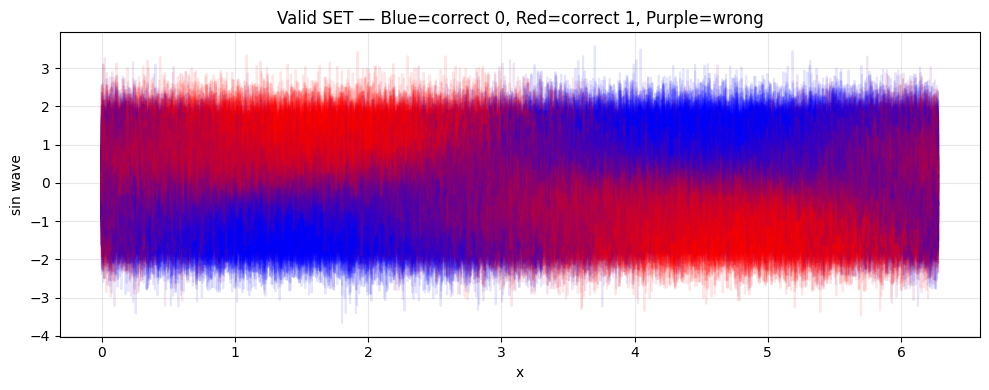

In [ ]:
plt.figure(figsize=(10, 4))
for sig, t, p in zip(X_val_np, y_val_np, y_val_pred_label):
    if t == 0 and p == 0:
        plt.plot(x, sig, color="blue", alpha=0.1)
    elif t == 1 and p == 1:
        plt.plot(x, sig, color="red", alpha=0.1)
    else:
        plt.plot(x, sig, color="purple", alpha=0.1)

plt.title("Valid SET — Blue=correct 0, Red=correct 1, Purple=wrong")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


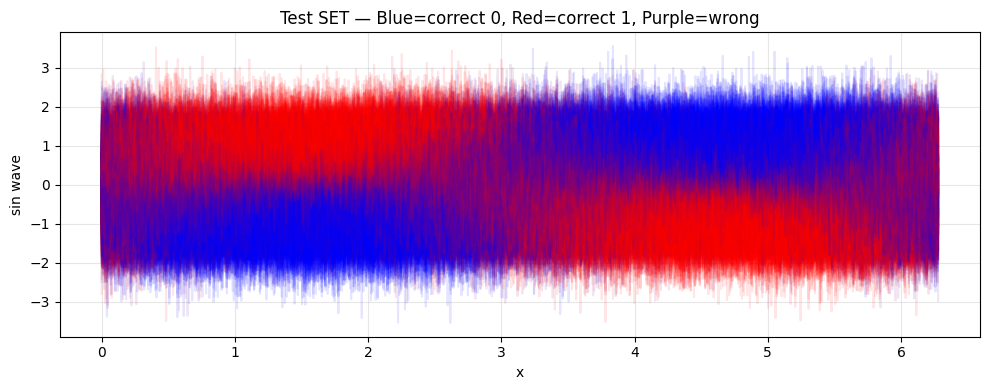

In [ ]:
plt.figure(figsize=(10, 4))
for sig, t, p in zip(X_test_np, y_test_np, y_test_pred_label):
    if t == 0 and p == 0:
        plt.plot(x, sig, color="blue", alpha=0.1)
    elif t == 1 and p == 1:
        plt.plot(x, sig, color="red", alpha=0.1)
    else:
        plt.plot(x, sig, color="purple", alpha=0.1)

plt.title("Test SET — Blue=correct 0, Red=correct 1, Purple=wrong")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

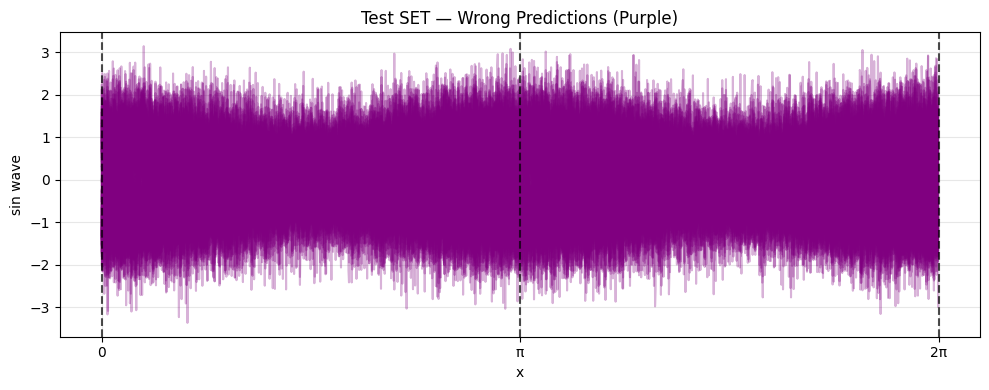

In [ ]:
plt.figure(figsize=(10, 4))
for sig, t, p in zip(X_test_np, y_test_np, y_test_pred_label):
    if t != p:
        plt.plot(x, sig, color="purple", alpha=0.3)

pi_val = np.pi
for xv in [0, pi_val, 2*pi_val]:
    plt.axvline(x=xv, color='black', linestyle='--', alpha=0.7)

plt.xticks([0, pi_val, 2*pi_val], ['0', 'π', '2π'])
plt.title("Test SET — Wrong Predictions (Purple)")
plt.xlabel("x")
plt.ylabel("sin wave")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 準確率(Accuracy)

In [ ]:
train_acc = np.mean(y_train_pred_label == y_train_np)
val_acc   = np.mean(y_val_pred_label   == y_val_np)
test_acc  = np.mean(y_test_pred_label  == y_test_np)

print("=== Accuracy ===")
print(f"Train Accuracy: {train_acc:.6f}")
print(f"Valid Accuracy: {val_acc:.6f}")
print(f"Test  Accuracy: {test_acc:.6f}\n")

=== Accuracy ===
Train Accuracy: 1.000000
Valid Accuracy: 0.846000
Test  Accuracy: 0.866000



#### 混淆矩陣(Confusion Matrix)

In [ ]:
def plot_confusion_matrix_custom(cm, title="Confusion Matrix"):
    color_matrix = np.ones((2,2,3))

    color_matrix[0,0] = [0.4, 0.6, 1.0]
    color_matrix[1,1] = [1.0, 0.4, 0.4]

    plt.figure(figsize=(4,4))
    plt.imshow(color_matrix, interpolation='nearest')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if (i==0 and j==0) or (i==1 and j==1):
                text_color = 'white'
            else:
                text_color = 'black'
            plt.text(j, i, str(cm[i,j]),
                     ha='center', va='center',
                     fontsize=16,
                     color=text_color)

    plt.xticks([0,1], ['Pred 0','Pred 1'])
    plt.yticks([0,1], ['True 0','True 1'])

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


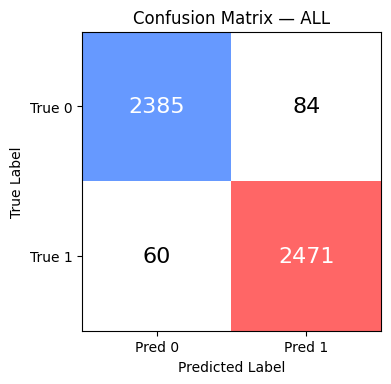

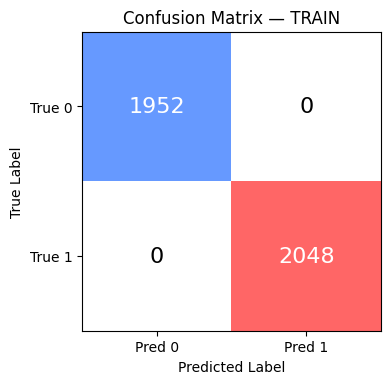

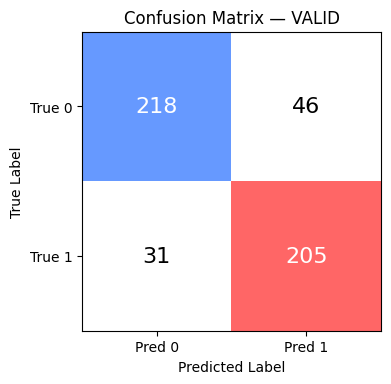

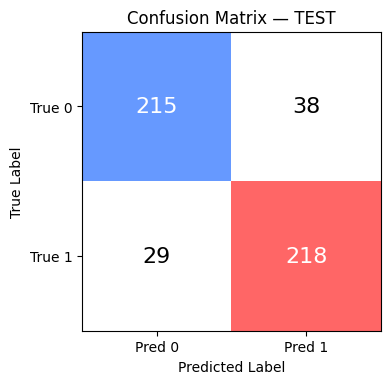

In [ ]:
cm_train = confusion_matrix(y_train_np, y_train_pred_label)
cm_val   = confusion_matrix(y_val_np,   y_val_pred_label)
cm_test  = confusion_matrix(y_test_np,  y_test_pred_label)

y_all_true  = np.concatenate([y_train_np, y_val_np, y_test_np])
y_all_pred  = np.concatenate([y_train_pred_label, y_val_pred_label, y_test_pred_label])
cm_all = confusion_matrix(y_all_true, y_all_pred)

plot_confusion_matrix_custom(cm_all,  "Confusion Matrix — ALL")
plot_confusion_matrix_custom(cm_train, "Confusion Matrix — TRAIN")
plot_confusion_matrix_custom(cm_val,   "Confusion Matrix — VALID")
plot_confusion_matrix_custom(cm_test,  "Confusion Matrix — TEST")

